Library imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy 

Data Pull

In [2]:
# dataset source
# https://www.kaggle.com/datasets/airbnb/seattle/data

calendar_df = pd.read_csv('./data/seattle_airbnb/calendar.csv')
calendar_df.head()

listings_df = pd.read_csv('./data/seattle_airbnb/listings.csv')
listings_df_original = copy.deepcopy(listings_df)
listings_df.head()

reviews_df = pd.read_csv('./data/seattle_airbnb/reviews.csv')
reviews_df.head()




,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


In [ ]:
calendar_df.groupby('listing_id')['date'].agg(['min', 'max'])
#looks pretty consistent on the date range for everyone
#we'll assume that everyone's calendar is for the same date range

,min,max
listing_id,,
3335,2016-01-04,2017-01-02
4291,2016-01-04,2017-01-02
5682,2016-01-04,2017-01-02
6606,2016-01-04,2017-01-02
7369,2016-01-04,2017-01-02
...,...,...
10332096,2016-01-04,2017-01-02
10334184,2016-01-04,2017-01-02
10339144,2016-01-04,2017-01-02


In [ ]:
## Convert data to new format
def create_rental_df(calendar_df, listings_df):
    ''' 
    Converts the calendar dataframe to the new rental format
    Reorganizing it from the individual day level to an aggregation for each rental period
    input:  dataframe version of calendar.csv
            detaframe version of listing.csv used for default price if needed
    output: rental_df
    format: listing_id  start_date  daily_price total_price(daily_price * duration) duration(day count of the rental period)
    '''

    results_list = []
    #loop separetely through each listing
    for listing_iter in calendar_df['listing_id'].unique():
        #version of calendar_df that si ONLY for that listing
        calendar_iter = copy.deepcopy( calendar_df[calendar_df['listing_id'] == listing_iter].sort_values(by=['date']) )

        last_booking_price = 0
        in_use = None  # if the listing booked that day? normally 1/0 but starts with None for cold start issues


        #float(calendar_iter.loc[0, 'price'].replace('$', ''))


        start_date = None
        daily_price = 0
        total_price = 0
        duration = 0
        #looping through each row
        #for each row it'll check if this is 
            # the start of a rental, 
            # the end of a rental, 
            # the continuation of a rental, 
            # or just another non rental day
        for listing_id, date, available, price in calendar_iter.values.tolist():
            #converting price to a number
            if isinstance(price, str):
                price = float(price.replace('$', '').replace(',', '') ) 
            # not booked
            if available == 't':
                #this checks if it was available in the previous day
                if in_use ==1:
                    #a stay just ended
                    results_list.append([listing_id, start_date, daily_price, total_price, duration])
                #reset
                start_date = None
                daily_price = 0
                total_price = 0
                duration = 0

                #not in use
                last_booking_price = price
                in_use = 0

            # booked
            elif available == 'f':
                duration = duration +1
                daily_price = last_booking_price
                if in_use ==0:
                    #first day of a stay
                    start_date = date
                    in_use = 1
                    total_price = last_booking_price

                elif in_use == None:
                    #year starts with a booking
                    in_use = 1
                    start_date = date 
                    price = calendar_iter['price'].dropna()
                    if len(price) == 0:
                        #it was booked every day. So we don't have the data needed. So we're grabbing the default price
                        price = listings_df[listings_df['id'] == listing_iter]['price'].iloc[0]  
                    else: 
                        price = price.reset_index(drop = True )[0] 
                    if isinstance(price, str):
                        #converting price to float again if needed after using listings_df, etc
                        price = float(price.replace('$', '').replace(',', '') ) 
                    last_booking_price = price 
                    daily_price = last_booking_price 
                    total_price = last_booking_price 
                else:
                    #not the first day of a stay
                    total_price = total_price + last_booking_price
                    in_use = 1
        if in_use ==1:
            results_list.append([listing_id, start_date, daily_price, total_price, duration])

    rental_df = pd.DataFrame(results_list, columns=['listing_id', 'start_date', 'daily_price', 'total_price', 'duration']) 
    return rental_df           

        

In [ ]:
## data now organized by listing, start date, the normal daily cost of the location, the duration of the stay, and the total cost (daily_price * duration)
rental_df = create_rental_df(calendar_df, listings_df)
rental_df.head()



,listing_id,start_date,daily_price,total_price,duration
0,241032,2016-01-06,85.0,595.0,7
1,241032,2016-01-15,85.0,255.0,3
2,241032,2016-01-21,85.0,255.0,3
3,241032,2016-01-29,85.0,255.0,3
4,241032,2016-02-11,85.0,255.0,3


In [ ]:
#saving a copy so we don't need to re-read the file
rental_df_original = copy.deepcopy(rental_df) 


## Question 1:  
How does the listing's summay, space, and description length impact the annual income.

In [7]:

#first we'll calculate the avarage monthly income
rental_df['year_month'] = pd.to_datetime(rental_df.start_date).dt.to_period('M')

rental_df.head() 


,listing_id,start_date,daily_price,total_price,duration,year_month
0,241032,2016-01-06,85.0,595.0,7,2016-01
1,241032,2016-01-15,85.0,255.0,3,2016-01
2,241032,2016-01-21,85.0,255.0,3,2016-01
3,241032,2016-01-29,85.0,255.0,3,2016-01
4,241032,2016-02-11,85.0,255.0,3,2016-02


In [ ]:
#calculating the annual income of the listing
#first getting the monthly income, and then further aggregating to the annual level
listing_main_df = rental_df.groupby(['listing_id', 'year_month'])['total_price'].sum().reset_index(drop=False).groupby(['listing_id'])['total_price'].sum().reset_index(drop = False).rename(columns = {'total_price': 'annual_income'}) 
listing_main_df.head() 

#blag = rental_df.groupby(['listing_id', 'year_month'])['total_price'].sum().reset_index(drop=False).groupby(['listing_id'])['total_price'].sum().reset_index(drop = False).rename(columns = {'total_price': 'annual_income'}) 
#blag[blag['listing_id'] == 3345341]
#blag.head() 




,listing_id,annual_income
0,3335,6720.0
1,5682,2927.0
2,7369,26520.0
3,9460,36662.0
4,9531,32465.0


In [9]:
# next we need to calculate the description length
# for this we're joining summary, space, and description as they seem to have partially overlapping purposes
listing_trunc_df = listings_df[['id', 'summary', 'space', 'description']].fillna('')

listing_trunc_df['total_description'] = listing_trunc_df['summary'] + listing_trunc_df['space'] + listing_trunc_df['description']


In [10]:
# calculating the numeric value
listing_trunc_df['descrp_length'] = [len(x) for x in listing_trunc_df['total_description']]


In [ ]:
#joining the data together so for a listing we have income and description length
listing_main_df = pd.merge(left = listing_main_df, right= listing_trunc_df, how = 'inner', left_on='listing_id', right_on='id')[['listing_id', 'annual_income', 'descrp_length']]

listing_main_df.head() 

,listing_id,annual_income,descrp_length
0,3335,6720.0,2057
1,5682,2927.0,2267
2,7369,26520.0,1270
3,9460,36662.0,2315
4,9531,32465.0,2247


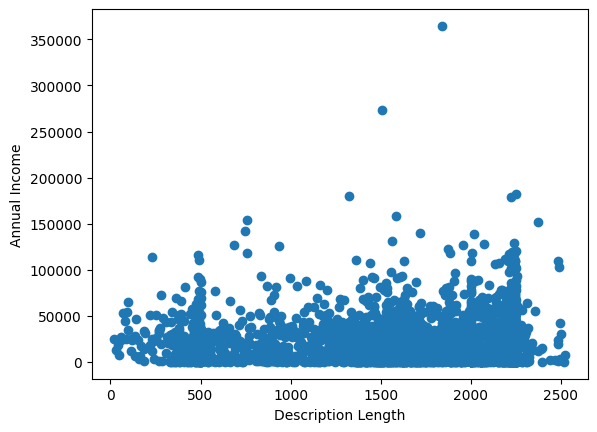

In [12]:
# Plot of length vs income

plt.scatter(listing_main_df['descrp_length'], listing_main_df['annual_income'])
plt.xlabel('Description Length') 
plt.ylabel('Annual Income') 
plt.show() 

Looking at the graph, I see no relationship.  
We have listings with short descriptions and a monthly income of $100,000 and listings with long descriptions pulling a similar monthly income.  
Let's check correlation just in case.

In [13]:
correlation = listing_main_df['descrp_length'].corr(listing_main_df['annual_income']) 
print('Correlation: ' + str(correlation))

Correlation: -0.029043484204247277


With a correlation so close to zero, I feel confident saying that the length of the listing's description has minimal impact on how much money the owner is likely to bring in each month.

It is worth noting that there are a few outliers who were booked year round

However, even if we remove the outliers, the graph does not indicate a strong relationship between the two.

## Question 2:  
Does local vs distant hosts impact the average review sentiment

In [ ]:
#library input again
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy 
from textblob import TextBlob 
import re 


c:\Program Files\Python39\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [9]:
# dataset source
# https://www.kaggle.com/datasets/airbnb/seattle/data

#calendar_df = pd.read_csv('./data/seattle_airbnb/calendar.csv')
#calendar_df.head()

listings_df = pd.read_csv('./data/seattle_airbnb/listings.csv')
listings_df_original = copy.deepcopy(listings_df)
listings_df.head()

reviews_df = pd.read_csv('./data/seattle_airbnb/reviews.csv')
review_df_original = copy.deepcopy(reviews_df)
reviews_df.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


In [ ]:
#filtering down to just the listing id and the host location
listings_df = listings_df[['id', 'host_location']]
listings_df.head() 

,id,host_location
0,241032,"Seattle, Washington, United States"
1,953595,"Seattle, Washington, United States"
2,3308979,"Seattle, Washington, United States"
3,7421966,"Seattle, Washington, United States"
4,278830,"Seattle, Washington, United States"


We'll need to identify if the host is local to Seattle or not.  
We'll also need to calculate the sentiment for comments about their property.

In [ ]:

def get_locality(location_text):
    ''' 
    determines if the host is located near (within the state) the listing
    input:  text from the host_location column for a listing
    output: 1/0  1 means they are close, 0 means they are out of state
    '''
    locality = 0
    try:
        location_text.lower()
    except:
        return 0
    # a manual check found these words appearing means the host is local
    if bool(re.search('seattle|house|home', location_text.lower() )):
        locality = 1
    # want to make sure we're not tagging Washington DC as local to Washington State
    elif (bool(re.search('wa|washington', location_text.lower() )) & bool(not re.search('dc', location_text.lower() ))):
        locality = 1
    else:
        locality = 0
    return locality 


In [ ]:
# adding the host locality flag to the dataframe
listings_df['locality'] = listings_df['host_location'].apply(get_locality)
listings_df.head()


,id,host_location,locality
0,241032,"Seattle, Washington, United States",1
1,953595,"Seattle, Washington, United States",1
2,3308979,"Seattle, Washington, United States",1
3,7421966,"Seattle, Washington, United States",1
4,278830,"Seattle, Washington, United States",1


In [ ]:
#resetting reviews_df to the original
reviews_df = copy.deepcopy(review_df_original)
reviews_df.head()


,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


In [ ]:
def get_sentiment(comment_text):
    ''' 
    Calculates the sentiment of a text 
    input: a string (expected: a listing review)
    output: a number. positive means happy/positive 
    '''
    try:
        return TextBlob(comment_text).sentiment.polarity
    except:
        return None

In [ ]:
#filtering down to the review comments along with the listing and review ids
reviews_df = reviews_df[['listing_id', 'id', 'comments']]
reviews_df.rename(columns={'id': 'review_id'}, inplace=True)
reviews_df.head()

,listing_id,review_id,comments
0,7202016,38917982,Cute and cozy place. Perfect location to every...
1,7202016,39087409,Kelly has a great room in a very central locat...
2,7202016,39820030,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,Close to Seattle Center and all it has to offe...
4,7202016,41986501,Kelly was a great host and very accommodating ...


In [ ]:
#adds the sentiment column to the dataset
reviews_df['sentiment'] = reviews_df['comments'].apply(get_sentiment)
reviews_df.head()

,listing_id,review_id,comments,sentiment
0,7202016,38917982,Cute and cozy place. Perfect location to every...,0.433333
1,7202016,39087409,Kelly has a great room in a very central locat...,0.301136
2,7202016,39820030,"Very spacious apartment, and in a great neighb...",0.410417
3,7202016,40813543,Close to Seattle Center and all it has to offe...,0.358333
4,7202016,41986501,Kelly was a great host and very accommodating ...,0.493485


In [ ]:
# now we have a dataframe with both locality and sentiment
listing_sentiment_df = pd.merge(left = listings_df, right = reviews_df, how = 'inner', left_on = 'id', right_on = 'listing_id', suffixes=('_x', '_y'))
listing_sentiment_df = listing_sentiment_df[['id', 'listing_id', 'sentiment', 'locality']]
listing_sentiment_df.head()



,id,listing_id,sentiment,locality
0,241032,241032,0.261699,1
1,241032,241032,0.567857,1
2,241032,241032,0.744444,1
3,241032,241032,0.229687,1
4,241032,241032,0.325521,1


In [ ]:
#calculating correlation between locality and sentiment
correlation = listing_sentiment_df['locality'].corr(listing_sentiment_df['sentiment']) 
print('Correlation: ' + str(correlation))

Correlation: 0.000694286452907507


There's roughly 0 correlation between whether the host is local and if the listing has good or bad reviews.   
Let's plot it to better see the distribution

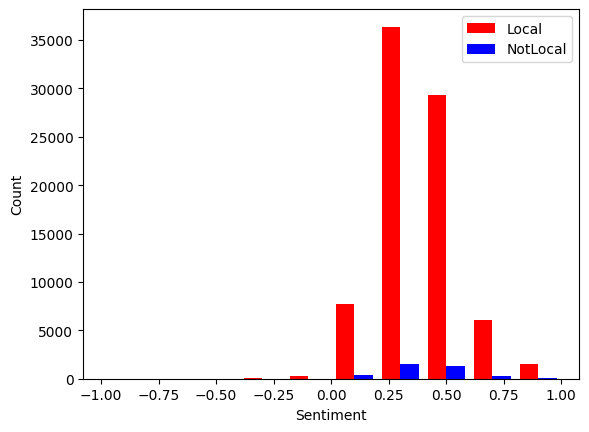

In [24]:
locality_1 = listing_sentiment_df[listing_sentiment_df['locality'] ==1]['sentiment']
locality_0 = listing_sentiment_df[listing_sentiment_df['locality'] ==0]['sentiment']
plt.hist([locality_1, locality_0], color = ['Red', 'Blue'], label=['Local', 'NotLocal'])
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.legend()
plt.show()


We see that on average comments are vaguely positive, and while most of the hosts are local, the distribution seems to be largely the same.  

So we have determined that no, locality does not impact a listings comments.

## Question 3:  
What factors lead to a listing's rental rate.

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import copy 
import numpy as np 

c:\Program Files\Python39\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [8]:
# dataset source
# https://www.kaggle.com/datasets/airbnb/seattle/data

#calendar_df = pd.read_csv('./data/seattle_airbnb/calendar.csv')
#calendar_df.head()

listings_df = pd.read_csv('./data/seattle_airbnb/listings.csv')
listings_df_original = copy.deepcopy(listings_df)
listings_df.head()

reviews_df = pd.read_csv('./data/seattle_airbnb/reviews.csv')
review_df_original = copy.deepcopy(reviews_df)
reviews_df.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


In [ ]:
## data now organized by listing, start date, the normal daily cost of the location, the duration of the stay, and the total cost (daily_price * duration)
rental_df = create_rental_df(calendar_df, listings_df)
rental_df.head()

,listing_id,start_date,daily_price,total_price,duration
0,241032,2016-01-06,85.0,595.0,7
1,241032,2016-01-15,85.0,255.0,3
2,241032,2016-01-21,85.0,255.0,3
3,241032,2016-01-29,85.0,255.0,3
4,241032,2016-02-11,85.0,255.0,3


In [ ]:
#renaming the id column from listings to match the name in other tables
listings_df.rename(columns={'id': 'listing_id'}, inplace=True)


In [ ]:
#filtering down to columns we care about
listings_df = listings_df[['listing_id', 'transit', 'host_about', 'host_total_listings_count', 'accommodates', 'bathrooms', 
                           'bedrooms', 'beds', 'price', 'minimum_nights', 'review_scores_rating', 'review_scores_cleanliness', 
                           'review_scores_communication', 'review_scores_location', 'host_response_time', 'host_has_profile_pic', 
                           'cancellation_policy', 'instant_bookable']]


In [ ]:
#for columns that will be converted into character lengths, we're replacing blanks with '' [0 length string]
#This is because from a user perspective, not filling in a comment box is the same as leaving it blank, which is a 0 length string.
#host_response_time is categorical, so converting to a string that is a usable category
listings_df[['transit', 'host_about', 'host_response_time']] = listings_df[['transit', 'host_about', 'host_response_time']].fillna('')


In [ ]:
#converting price to a float
#calculating string lengths for select columns
listings_df['transit_length'] = [len(x) for x in listings_df['transit']]
listings_df['host_length'] = [len(x) for x in listings_df['host_about']]
listings_df['price'] = [float(x.replace('$', '').replace(',', '')) for x in listings_df['price']]

Checking data loss if we drop all rows that have any NaNs. (after we fixed the above NaNs)

In [44]:
listings_df.shape

(3818, 20)

In [ ]:
listings_df.dropna(axis = 0).shape

(3143, 20)

If we drop all the rows with NaNs, we'll only lose ~20% of the rows. For now we'll assume that there is no information in the numeric NaNs. And while 20% is a lot for a production model, that loss is acceptable for a descriptive model.

In [ ]:
#dropping rows with Nans given above statement
listings_df.dropna(axis = 0, inplace=True)


In [16]:
listings_df.head()

,listing_id,transit,host_about,host_total_listings_count,accommodates,bathrooms,bedrooms,beds,price,minimum_nights,review_scores_rating,review_scores_cleanliness,review_scores_communication,review_scores_location,host_response_time,host_has_profile_pic,cancellation_policy,instant_bookable,transit_length,host_length
0,241032,,"I am an artist, interior designer, and run a s...",3.0,4,1.0,1.0,1.0,85.0,1,95.0,10.0,10.0,9.0,within a few hours,t,moderate,f,0,372
1,953595,"Convenient bus stops are just down the block, ...",Living east coast/left coast/overseas. Time i...,6.0,4,1.0,1.0,1.0,150.0,2,96.0,10.0,10.0,10.0,within an hour,t,strict,f,162,74
2,3308979,A bus stop is just 2 blocks away. Easy bus a...,i love living in Seattle. i grew up in the mi...,2.0,11,4.5,5.0,7.0,975.0,4,97.0,10.0,10.0,10.0,within a few hours,t,strict,f,202,343
4,278830,The nearest public transit bus (D Line) is 2 b...,"Hi, I live in Seattle, Washington but I'm orig...",2.0,6,2.0,3.0,3.0,450.0,1,92.0,9.0,10.0,9.0,within an hour,t,strict,f,295,354
5,5956968,The #1 and #2 bus picks up 2-3 blocks away (di...,I've been fortunate to have had many life expe...,1.0,2,1.0,1.0,1.0,120.0,1,95.0,10.0,10.0,10.0,,t,strict,f,102,236


Now we need to calculate our target variable

In [17]:
rental_df.head()

,listing_id,start_date,daily_price,total_price,duration
0,241032,2016-01-06,85.0,595.0,7
1,241032,2016-01-15,85.0,255.0,3
2,241032,2016-01-21,85.0,255.0,3
3,241032,2016-01-29,85.0,255.0,3
4,241032,2016-02-11,85.0,255.0,3


In [ ]:
# counting the number of bookings for each listing_id
rental_df = rental_df[['listing_id', 'start_date']].groupby('listing_id').count().reset_index(drop = False)
rental_df.head()


,listing_id,start_date
0,3335,1
1,5682,12
2,7369,4
3,9460,11
4,9531,3


In [ ]:
#renaming cus groupby().agg gives bad column names
rental_df.rename(columns={'start_date':'booking_count'}, inplace=True)


In [ ]:
#joining together the dataset with the target variable (booking_count) and the dataset with the independent variables
df = pd.merge(left = rental_df, right = listings_df, on = 'listing_id')
df.drop('transit', axis=1, inplace=True)
df.drop('host_about', axis=1, inplace=True)
df.head()

,listing_id,booking_count,host_total_listings_count,accommodates,bathrooms,bedrooms,beds,price,minimum_nights,review_scores_rating,review_scores_cleanliness,review_scores_communication,review_scores_location,host_response_time,host_has_profile_pic,cancellation_policy,instant_bookable,transit_length,host_length
0,5682,12,1.0,2,1.0,1.0,1.0,48.0,3,96.0,10.0,10.0,9.0,within an hour,t,strict,t,1000,232
1,7369,4,1.0,2,1.0,1.0,1.0,85.0,1,94.0,10.0,10.0,10.0,,t,flexible,f,108,268
2,9460,11,2.0,2,1.0,1.0,1.0,99.0,3,98.0,10.0,10.0,10.0,within an hour,t,moderate,t,155,350
3,9531,3,2.0,4,1.0,2.0,5.0,165.0,3,100.0,10.0,10.0,10.0,within an hour,t,strict,f,216,805
4,9534,4,2.0,3,1.0,2.0,2.0,125.0,2,100.0,10.0,10.0,10.0,within an hour,t,strict,f,237,805


In [21]:
df.columns

Index(['listing_id', 'booking_count', 'host_total_listings_count',
       'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price',
       'minimum_nights', 'review_scores_rating', 'review_scores_cleanliness',
       'review_scores_communication', 'review_scores_location',
       'host_response_time', 'host_has_profile_pic', 'cancellation_policy',
       'instant_bookable', 'transit_length', 'host_length'],
      dtype='object')

In [22]:
df[['cancellation_policy', 'instant_bookable', 'transit_length']].head()

,cancellation_policy,instant_bookable,transit_length
0,strict,t,1000
1,flexible,f,108
2,moderate,t,155
3,strict,f,216
4,strict,f,237


In [23]:
pd.get_dummies(df['cancellation_policy']).head()

,flexible,moderate,strict
0,False,False,True
1,True,False,False
2,False,True,False
3,False,False,True
4,False,False,True


Creating dummy variables for applicable categorical variables

In [24]:
df = pd.concat([df, pd.get_dummies(df['cancellation_policy'])], axis=1)
df.drop('cancellation_policy', axis=1, inplace=True)
df = pd.concat([df, pd.get_dummies(df['host_response_time'])], axis=1)
df.drop('host_response_time', axis=1, inplace=True)
df['instant_bookable'] = df['instant_bookable'].replace({'t':True, 'f':False})
df['host_has_profile_pic'] = df['host_has_profile_pic'].replace({'t':True, 'f':False})
df.head()

C:\Users\u028031\AppData\Local\Temp\ipykernel_15504\2271878692.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['instant_bookable'] = df['instant_bookable'].replace({'t':True, 'f':False})
C:\Users\u028031\AppData\Local\Temp\ipykernel_15504\2271878692.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['host_has_profile_pic'] = df['host_has_profile_pic'].replace({'t':True, 'f':False})


,listing_id,booking_count,host_total_listings_count,accommodates,bathrooms,bedrooms,beds,price,minimum_nights,review_scores_rating,...,transit_length,host_length,flexible,moderate,strict,,a few days or more,within a day,within a few hours,within an hour
0,5682,12,1.0,2,1.0,1.0,1.0,48.0,3,96.0,...,1000,232,False,False,True,False,False,False,False,True
1,7369,4,1.0,2,1.0,1.0,1.0,85.0,1,94.0,...,108,268,True,False,False,True,False,False,False,False
2,9460,11,2.0,2,1.0,1.0,1.0,99.0,3,98.0,...,155,350,False,True,False,False,False,False,False,True
3,9531,3,2.0,4,1.0,2.0,5.0,165.0,3,100.0,...,216,805,False,False,True,False,False,False,False,True
4,9534,4,2.0,3,1.0,2.0,2.0,125.0,2,100.0,...,237,805,False,False,True,False,False,False,False,True


In [25]:
# and now to start the model building 
y = df['booking_count']
df.drop('booking_count', axis=1, inplace=True)
X = copy.deepcopy(df)


In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3)
lm_model = LinearRegression()
lm_model.fit(X_train, y_train)

LinearRegression()

Saving the model coeficients to a series. 
We're using absolute value, as we're looking for scale of impact, not which is the highest positive value.

In [ ]:
model_coef_pct = pd.Series([round(np.abs(x)/sum(np.abs(lm_model.coef_)), 5) for x in lm_model.coef_], index = df.columns).sort_values( ascending = False)
model_coef_pct[0:10]


                          0.14917
host_has_profile_pic      0.13760
within an hour            0.10455
instant_bookable          0.10379
a few days or more        0.07984
within a few hours        0.07027
bedrooms                  0.06816
beds                      0.05946
within a day              0.05419
review_scores_location    0.04582
dtype: float64

From this we see that the factors that have the greatest impact on the number of bookings a listing had over the year.  

Whether or not the guest knows what the host looks like
How quickly the host responds to communications
Whether or not the listing is instantly bookable
And then the number of bedrooms and the number of beds.
